# Imports

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

# nltk.download('wordnet')

In [2]:
SEED = 42

# Data reading

In [3]:
raw_data = pd.read_json("data/pycharm_issues.json", lines=True)

raw_data.summary = raw_data.summary.astype("string")
raw_data.description = raw_data.description.astype("string")
raw_data["versions"] = raw_data["Affected versions"]
raw_data.drop(columns="Affected versions", inplace=True)

In [4]:
raw_data.head()

idReadable        created  \
0   PY-22135  1483471995465   
1   PY-22143  1483528763930   
2   PY-22145  1483545972098   
3   PY-22149  1483572086024   
4   PY-22128  1483387969625   

                                             summary  \
0  "Parameter foo unfilled": false positives for ...   
1  Python Extract Superclass: Incorrect Order of ...   
2  Inspection does not report 'Unresolved Referen...   
3        ipython notebook clear_output() not working   
4  False negative: no error for round brackets in...   

                                         description  versions  
0  I'm getting false "Incorrect call argument" in...  [2016.3]  
1  When extracting superclasses, if extractions i...  [2016.3]  
2  If a variable is deleted using the `del` state...  [2016.2]  
3  Below code should print only once "Hellow Worl...        []  
4  I believe it's rather a common typo to use rou...  [2017.1]

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22014 entries, 0 to 22013
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   idReadable   22014 non-null  object
 1   created      22014 non-null  int64 
 2   summary      22014 non-null  string
 3   description  21832 non-null  string
 4   versions     22014 non-null  object
dtypes: int64(1), object(2), string(2)
memory usage: 860.0+ KB


In [6]:
versions = np.hstack(raw_data.versions.values)        
versions = np.unique(versions)[-5:]
print(versions)

['2020.2' '2020.3' '2021.1' '2021.2' '2021.3']


In [7]:
def filter_versions(value, versions=('2020.2', '2020.3', '2021.1', '2021.2', '2021.3')):
    for ver in value:
        if ver in versions:
            return True
    return False

In [8]:
msk = raw_data.versions.apply(lambda x: filter_versions(x, versions))
msk.sum()

2296

In [9]:
data = raw_data[msk]
data.head()

idReadable        created  \
45    PY-22211  1484097590051   
67    PY-22248  1484322653638   
178   PY-22369  1485334537463   
266   PY-22469  1485863013851   
730   PY-23007  1488923938785   

                                               summary  \
45   Running subprocesses with Popen inside unittes...   
67   Full project optimize imports alters library f...   
178  DataFrame auto-update doesn't work with action...   
266          PowerShell prompt doesn't show virtualenv   
730  Project requirements are not detected from set...   

                                           description  versions  
45   I have the following unittest:

```
class MyTe...  [2020.3]  
67   Reported by: @matheusbrat on Twitter: https://...  [2020.2]  
178  Consider this example:

```python
import panda...  [2021.1]  
266  Although the virtualenv seems activated, the p...  [2021.1]  
730  Since setuptools 30.3.0 it's possible to speci...  [2020.3]

# Data preprocessing

In [10]:
def flt(value):
    text = str(value)
    stop_words = set(stopwords.words("english") + ["`", ":", "'", ",", ".", "I'm", "``", "'s", "@", "n't"])
    word_tokens = word_tokenize(text)
    filtered = [w for w in word_tokens if not w.lower() in stop_words]
    return " ".join(filtered)

In [11]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)
stop_words = set(stopwords.words("english") + ["`", ":", "'", ",", ".", "I'm", "``", "'s", "@", "n't"])


def lemmatizing(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos="v"))


def preprocess(value):
    text = str(value)
    tokens = simple_preprocess(text)
    
    filtered = [lemmatizing(w) for w in tokens if not w in stop_words and len(w) > 3]
    return filtered

# LDA

In [12]:
def test_coherence(corpus, topic_range, dictionary):
    out = []
    
    for num_of_topics in tqdm(topic_range):
        model = LdaModel(corpus, num_of_topics, random_state=SEED)
        out.append(CoherenceModel(model, corpus=corpus, coherence="u_mass", dictionary=dictionary).get_coherence())
        
    return out

In [13]:
def test_model(data, topics_range):
    data = data.map(preprocess)
    
    dictionary = gensim.corpora.Dictionary(data)
    dictionary.filter_extremes()
    
    corpus = [dictionary.doc2bow(text) for text in data]
    
    coherences = test_coherence(corpus, topics_range, dictionary)

    plt.plot(topics_range, coherences)
    plt.xlabel("number of topics")
    plt.ylabel("Coherence")
    plt.show()


def get_solution(data, num_topics):
    data = data.map(preprocess)
    
    dictionary = gensim.corpora.Dictionary(data)
    dictionary.filter_extremes()
    
    corpus = [dictionary.doc2bow(text) for text in data]
    
    model = LdaModel(corpus, num_topics, random_state=SEED, id2word=dictionary)

    vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary, mds="mmds")
        
    return model, vis


def get_major_topic(model):
    for idx, topic in model.print_topics(-1):
        print(f"Topic: {idx + 1} \nWords: {topic}")
    

## Summaries

100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


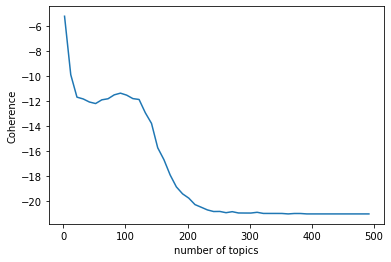

In [14]:
test_model(data.summary, range(2, 500, 10))

по данной метрике стоит выбрать около 100 топиков. Возьмем такое количество и посмотрим, что выйдет.

In [15]:
summary_model, vis = get_solution(data.summary, 100)

/home/breengles/.pyenv/versions/3.8.11/envs/ml/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/home/breengles/.pyenv/versions/3.8.11/envs/ml/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/breengles/.pyenv/versions/3.8.11/envs/ml/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/breengles/.pyenv/versions/3.8.11/envs/ml/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alte

In [16]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
36    -0.379389  0.235866       1        1  2.312414
99    -0.001569  0.356527       2        1  2.021494
44     0.296902 -0.340385       3        1  1.892040
26    -0.273036 -0.358121       4        1  1.891280
90     0.415021  0.140886       5        1  1.727521
...         ...       ...     ...      ...       ...
47     0.056492  0.188602      96        1  0.574363
21     0.031583  0.082950      97        1  0.504928
20    -0.071755  0.058819      98        1  0.494512
69    -0.039677 -0.098246      99        1  0.340333
56     0.039654 -0.093477     100        1  0.329015

[100 rows x 5 columns], topic_info=         Term        Freq       Total  Category  logprob  loglift
65       type  389.000000  389.000000   Default  30.0000  30.0000
47     python  334.000000  334.000000   Default  29.0000  29.0000
7        file  156.000000  156.000000   Default  28.0000  28.0000
8      import  193.000000  193.000000   Default  27.0000  27.0000
18       work  157.000000  157.000000   Default  26.0000  26.0000
..        ...         ...         ...       ...      ...      ...
157  configur    0.467856   62.091016  Topic100  -4.4776   0.8286
226   version    0.467854   37.628217  Topic100  -4.4776   1.3295
83       fals    0.467852  112.031715  Topic100  -4.4776   0.2384
138    docker    0.467852  108.154083  Topic100  -4.4776   0.2737
4         run    0.467852   41.015864  Topic100  -4.4776   1.2433

[4112 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
468      82  0.785654     abil
448       1  0.726451   accept
218       8  0.305484  account
218      18  0.305484  account
14       39  0.427731   action
...     ...       ...      ...
128      85  0.117899    wrong
128      97  0.016843    wrong
543      16  0.647252     yaml
543      79  0.258901     yaml
104       7  0.879609    yield

[2487 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[37, 100, 45, 27, 91, 2, 25, 89, 81, 41, 59, 49, 38, 61, 54, 82, 84, 20, 8, 51, 9, 93, 60, 95, 85, 72, 44, 68, 15, 98, 47, 35, 18, 63, 53, 28, 75, 13, 3, 55, 29, 56, 26, 52, 33, 24, 11, 31, 88, 79, 76, 65, 58, 77, 42, 74, 16, 78, 7, 40, 80, 94, 5, 34, 90, 97, 19, 96, 86, 62, 46, 71, 69, 50, 83, 4, 10, 30, 67, 1, 36, 12, 43, 14, 73, 64, 39, 6, 32, 66, 87, 17, 92, 99, 23, 48, 22, 21, 70, 57])

В основном, у людей проблемы с импортами и дебагом...

Еще проблемы с code completion, видимо, в импортах

Классические проблемы с юпитер ноутбуками и докером, хех

In [17]:
get_major_topic(summary_model)

Topic: 1 
Words: 0.079*"import" + 0.076*"error" + 0.072*"exist" + 0.072*"support" + 0.072*"termin" + 0.072*"activ" + 0.063*"modul" + 0.058*"matplotlib" + 0.057*"class" + 0.046*"inform"
Topic: 2 
Words: 0.165*"import" + 0.074*"find" + 0.070*"data" + 0.070*"freez" + 0.067*"type" + 0.065*"refer" + 0.049*"suggest" + 0.049*"modul" + 0.048*"cannot" + 0.042*"pycharm"
Topic: 3 
Words: 0.124*"jupyt" + 0.088*"use" + 0.059*"action" + 0.056*"checker" + 0.056*"editor" + 0.053*"context" + 0.053*"correct" + 0.053*"support" + 0.031*"type" + 0.030*"import"
Topic: 4 
Words: 0.232*"paramet" + 0.107*"enabl" + 0.057*"line" + 0.054*"argument" + 0.054*"without" + 0.054*"unexpect" + 0.054*"import" + 0.054*"execut" + 0.054*"point" + 0.048*"type"
Topic: 5 
Words: 0.109*"show" + 0.078*"view" + 0.074*"complet" + 0.074*"mark" + 0.074*"depend" + 0.070*"extend" + 0.070*"import" + 0.070*"suggest" + 0.070*"timeout" + 0.020*"variabl"
Topic: 6 
Words: 0.179*"paramet" + 0.179*"method" + 0.173*"namedtupl" + 0.062*"code" +

Всего за последние 5 релизов основные проблемы с импортами, видимо, бОльшая часть из них связана с тем, что пайчарм не видит библиотеки, которые на самом деле установлены у пользователя

## Descriptions

не было особо разумной предобработки описаний ишуй, но посмотреть все равно интересно

100%|██████████| 50/50 [03:21<00:00,  4.02s/it]


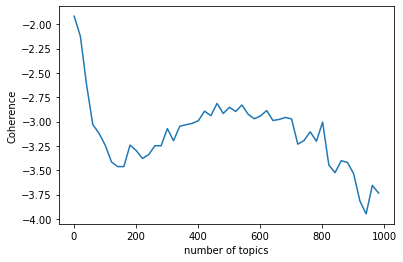

In [18]:
test_model(data.description, range(2, 1000, 20))

аналогично, выбираем около 500 топиков

In [19]:
desc_model, vis = get_solution(data.description, 500)

/home/breengles/.pyenv/versions/3.8.11/envs/ml/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [20]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15    -0.470364 -0.081379       1        1  9.493730
91    -0.320375  0.195469       2        1  5.541866
225   -0.408648 -0.088998       3        1  4.582381
228   -0.074034 -0.464906       4        1  4.135571
48    -0.063793 -0.467806       5        1  4.056777
...         ...       ...     ...      ...       ...
387   -0.134134 -0.306327     496        1  0.002577
383   -0.334009 -0.079124     497        1  0.002577
162   -0.173342 -0.133632     498        1  0.002577
170   -0.203507  0.057853     499        1  0.002577
499   -0.018013 -0.028772     500        1  0.002577

[500 rows x 5 columns], topic_info=          Term         Freq        Total  Category  logprob  loglift
58        java  7686.000000  7686.000000   Default  30.0000  30.0000
93   setuptool  3168.000000  3168.000000   Default  29.0000  29.0000
165      numpi  2972.000000  2972.000000   Default  28.0000  28.0000
137   intellij  3148.000000  3148.000000   Default  27.0000  27.0000
31       https  2635.000000  2635.000000   Default  26.0000  26.0000
..         ...          ...          ...       ...      ...      ...
202       show     0.031167   612.923566  Topic500  -4.9477   0.6797
143       like     0.028950   319.178437  Topic500  -5.0216   1.2584
135      error     0.031355  1004.100735  Topic500  -4.9418   0.1921
5       expect     0.030954  1274.616215  Topic500  -4.9546  -0.0593
69        work     0.028470   682.744038  Topic500  -5.0383   0.4813

[25675 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1599      2  0.074366     aarch
1599      6  0.074366     aarch
1599     15  0.074366     aarch
1599    226  0.074366     aarch
1599    288  0.594927     aarch
...     ...       ...       ...
426     154  0.013519  youtrack
426     159  0.013519  youtrack
426     231  0.054077  youtrack
564       5  0.190111      zero
564     110  0.570334      zero

[24496 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 92, 226, 229, 49, 85, 102, 88, 280, 207, 87, 169, 35, 230, 451, 97, 493, 191, 28, 231, 131, 334, 448, 238, 261, 115, 68, 469, 354, 320, 275, 267, 67, 242, 476, 244, 45, 423, 348, 202, 411, 90, 496, 467, 136, 196, 447, 103, 358, 370, 259, 86, 38, 237, 175, 291, 318, 356, 72, 170, 219, 315, 139, 65, 482, 470, 434, 122, 445, 209, 3, 314, 492, 129, 406, 408, 60, 165, 253, 124, 362, 140, 270, 82, 239, 105, 398, 491, 273, 186, 187, 382, 224, 13, 190, 421, 223, 347, 256, 371, 317, 11, 126, 26, 158, 416, 277, 137, 18, 355, 310, 27, 114, 468, 395, 162, 195, 216, 161, 145, 379, 153, 436, 452, 24, 127, 250, 499, 235, 249, 176, 40, 42, 460, 197, 472, 440, 58, 4, 268, 461, 166, 258, 227, 155, 199, 458, 400, 426, 21, 254, 265, 172, 181, 57, 281, 487, 322, 293, 32, 306, 368, 41, 46, 83, 232, 213, 272, 241, 308, 316, 329, 132, 463, 143, 5, 215, 301, 160, 217, 352, 412, 144, 168, 366, 413, 486, 454, 488, 12, 498, 44, 300, 110, 319, 344, 325, 341, 69, 260, 96, 222, 106, 134, 194, 336, 154, 156, 206, 243, 211, 296, 43, 15, 289, 120, 374, 274, 433, 178, 188, 389, 245, 484, 456, 10, 474, 494, 214, 118, 53, 117, 399, 373, 481, 212, 335, 359, 104, 180, 192, 17, 284, 299, 349, 357, 331, 437, 99, 305, 48, 174, 25, 52, 449, 360, 75, 330, 380, 442, 397, 303, 63, 477, 363, 324, 350, 497, 424, 228, 446, 203, 404, 164, 345, 98, 208, 263, 142, 367, 198, 189, 485, 297, 378, 62, 152, 94, 149, 428, 47, 295, 294, 393, 251, 112, 159, 39, 353, 403, 6, 30, 328, 346, 1, 236, 465, 61, 292, 392, 394, 386, 31, 340, 210, 407, 455, 91, 369, 304, 364, 56, 135, 466, 233, 262, 290, 323, 410, 84, 298, 495, 332, 179, 402, 390, 464, 431, 73, 288, 351, 252, 221, 271, 77, 405, 151, 109, 200, 66, 278, 313, 108, 462, 337, 130, 81, 385, 480, 220, 365, 111, 51, 478, 74, 376, 9, 146, 33, 309, 401, 435, 427, 396, 125, 302, 311, 415, 20, 167, 59, 205, 93, 279, 307, 339, 475, 44

In [21]:
get_major_topic(desc_model)

Topic: 1 
Words: 0.193*"async" + 0.139*"return" + 0.079*"regular" + 0.076*"self" + 0.054*"class" + 0.030*"code" + 0.021*"result" + 0.019*"reproduc" + 0.017*"step" + 0.016*"expect"
Topic: 2 
Words: 0.188*"instanti" + 0.033*"attribut" + 0.030*"line" + 0.028*"execut" + 0.025*"class" + 0.022*"code" + 0.022*"defin" + 0.022*"instanc" + 0.022*"warn" + 0.018*"step"
Topic: 3 
Words: 0.116*"type" + 0.088*"list" + 0.082*"tupl" + 0.077*"error" + 0.068*"sequenc" + 0.063*"expect" + 0.051*"union" + 0.049*"incompat" + 0.048*"none" + 0.033*"mypi"
Topic: 4 
Words: 0.071*"test" + 0.044*"save" + 0.042*"close" + 0.036*"plot" + 0.034*"figur" + 0.030*"valid" + 0.028*"run" + 0.026*"modul" + 0.025*"python" + 0.023*"click"
Topic: 5 
Words: 0.158*"mypi" + 0.140*"type" + 0.129*"plugin" + 0.062*"jetbrain" + 0.061*"check" + 0.050*"union" + 0.033*"imag" + 0.020*"code" + 0.019*"https" + 0.019*"exampl"
Topic: 6 
Words: 0.195*"interpret" + 0.176*"great" + 0.118*"open" + 0.112*"annoy" + 0.069*"configur" + 0.042*"base" +

Оо, проблемы с джавой в пайчарме? 

Вероятно, проблемы с библиотекой, т.к. описание содержит стэктрейсы, или с тем, что люди пишут свои плагины, и уже проблемы с ними...

Еще есть отдельные проблемы с нумпаем, но, это, скорее всего, опять таки следствие наличия стектрейсов

Вообще, видимо, чтобы получить от описания что-то более разумное, надо чистить от стэктрейсов каким-нибудь образом (?)

# 2020.2

In [22]:
msk = raw_data.versions.apply(lambda x: filter_versions(x, ("2020.2",)))
msk.sum()

625

In [23]:
data = raw_data[msk]
data.head()

idReadable        created  \
67     PY-22248  1484322653638   
967    PY-23199  1490083379095   
1227   PY-23558  1491299287883   
2167   PY-24622  1496901895623   
2799   PY-25291  1500917245745   

                                                summary  \
67    Full project optimize imports alters library f...   
967   Exception is raised if PyCharm has no permissi...   
1227  Django: Relative paths in include and extends ...   
2167  Python stub: unresolved submodule name string ...   
2799  Datetime Index for DataFrame is displayed with...   

                                            description          versions  
67    Reported by: @matheusbrat on Twitter: https://...          [2020.2]  
967   To reproduce try to specify some system path l...  [2017.1, 2020.2]  
1227  Since Django 1.10* it's possible to use relati...          [2020.2]  
2167  given a python stub file package with the foll...          [2020.2]  
2799  The new Data View in 172.3317.82 fixs the issu...          [2020.2]

100%|██████████| 50/50 [00:16<00:00,  3.01it/s]


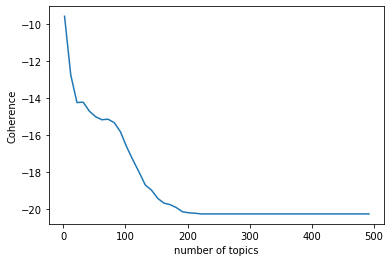

In [24]:
test_model(data.summary, range(2, 500, 10))

In [25]:
model, vis = get_solution(data.summary, 100)

/home/breengles/.pyenv/versions/3.8.11/envs/ml/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [26]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3      0.212892  0.371285       1        1  2.260276
68     0.312792  0.273024       2        1  2.103902
49    -0.299468  0.147082       3        1  1.740679
73    -0.045360  0.362051       4        1  1.691303
9     -0.263575  0.109651       5        1  1.665311
...         ...       ...     ...      ...       ...
12     0.017390 -0.011429      96        1  0.184550
96     0.017390 -0.011429      97        1  0.184550
11     0.017390 -0.011429      98        1  0.184550
10     0.017390 -0.011429      99        1  0.184550
50     0.017390 -0.011429     100        1  0.184550

[100 rows x 5 columns], topic_info=         Term       Freq      Total  Category  logprob  loglift
69       type  72.000000  72.000000   Default  30.0000  30.0000
16     python  84.000000  84.000000   Default  29.0000  29.0000
3     project  31.000000  31.000000   Default  28.0000  28.0000
1      import  33.000000  33.000000   Default  27.0000  27.0000
86  interpret  45.000000  45.000000   Default  26.0000  26.0000
..        ...        ...        ...       ...      ...      ...
23     global   0.024267  10.025343  Topic100  -5.3033   0.2712
24      modul   0.024267  25.132910  Topic100  -5.3033  -0.6478
25    variabl   0.024267  27.708119  Topic100  -5.3033  -0.7454
28       show   0.024267  22.364465  Topic100  -5.3033  -0.5311
29     cannot   0.024267  16.467322  Topic100  -5.3033  -0.2250

[4701 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
87        1  0.194233  action
87        2  0.194233  action
87        8  0.097116  action
87       23  0.097116  action
87       33  0.097116  action
...     ...       ...     ...
106      50  0.048974   wrong
106      54  0.048974   wrong
106      63  0.097947   wrong
106      68  0.048974   wrong
106      77  0.097947   wrong

[1295 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 69, 50, 74, 10, 86, 15, 73, 80, 36, 24, 59, 1, 33, 8, 75, 38, 57, 98, 20, 62, 5, 26, 65, 22, 28, 45, 56, 87, 37, 18, 6, 85, 2, 54, 92, 96, 48, 3, 99, 67, 39, 71, 46, 94, 32, 60, 93, 68, 79, 84, 78, 82, 14, 66, 31, 23, 76, 7, 41, 88, 61, 19, 34, 63, 90, 70, 91, 95, 77, 21, 40, 58, 42, 81, 52, 9, 43, 35, 83, 72, 53, 100, 27, 89, 64, 30, 47, 44, 49, 29, 55, 25, 17, 16, 13, 97, 12, 11, 51])

Основные проблемы с докером, с импортами, с неправильным определением типов (?) и краши в консоли (?)

In [27]:
get_major_topic(model)

Topic: 1 
Words: 0.138*"type" + 0.069*"fals" + 0.035*"open" + 0.035*"unabl" + 0.035*"cannot" + 0.035*"jupyt" + 0.035*"preview" + 0.035*"posit" + 0.035*"modul" + 0.035*"negat"
Topic: 2 
Words: 0.148*"type" + 0.074*"fail" + 0.074*"checker" + 0.037*"infer" + 0.037*"test" + 0.037*"correct" + 0.037*"wrong" + 0.037*"conda" + 0.037*"variabl" + 0.037*"tupl"
Topic: 3 
Words: 0.112*"work" + 0.112*"python" + 0.112*"sourc" + 0.056*"preview" + 0.056*"specifi" + 0.056*"inspect" + 0.056*"express" + 0.056*"code" + 0.056*"consol" + 0.056*"interpret"
Topic: 4 
Words: 0.139*"docker" + 0.084*"interpret" + 0.056*"base" + 0.056*"pycharm" + 0.056*"remot" + 0.056*"chang" + 0.056*"use" + 0.056*"compos" + 0.028*"code" + 0.028*"alway"
Topic: 5 
Words: 0.061*"execut" + 0.061*"test" + 0.061*"file" + 0.061*"slow" + 0.061*"python" + 0.061*"project" + 0.031*"enabl" + 0.031*"consol" + 0.031*"option" + 0.031*"drop"
Topic: 6 
Words: 0.100*"creat" + 0.050*"environ" + 0.050*"function" + 0.050*"global" + 0.050*"option" + 0

Очередные проблемы с юпитер ноутбуками...

# 2020.3

In [28]:
msk = raw_data.versions.apply(lambda x: filter_versions(x, ("2020.3",)))
msk.sum()

522

In [29]:
data = raw_data[msk]
data.head()

idReadable        created  \
45     PY-22211  1484097590051   
730    PY-23007  1488923938785   
4299   PY-27103  1511323304204   
6653   PY-29891  1525391390656   
7031   PY-30376  1528389637339   

                                                summary  \
45    Running subprocesses with Popen inside unittes...   
730   Project requirements are not detected from set...   
4299                 Mako: End of substitution expected   
6653  PyCharm doesn't infer AsyncContextManager type...   
7031   Copying of python helpers keeps failing silently   

                                            description  \
45    I have the following unittest:

```
class MyTe...   
730   Since setuptools 30.3.0 it's possible to speci...   
4299  PyCharm erroneously reports syntax error: "End...   
6653  **What steps will reproduce the problem?**
Con...   
7031  Whenever I try to reconfigure the remote execu...   

                              versions  
45                            [2020.3]  
730                           [2020.3]  
4299                  [2020.3, 2017.2]  
6653                          [2020.3]  
7031  [2020.3, 2021.1, 2018.1, 2021.2]

100%|██████████| 50/50 [00:14<00:00,  3.35it/s]


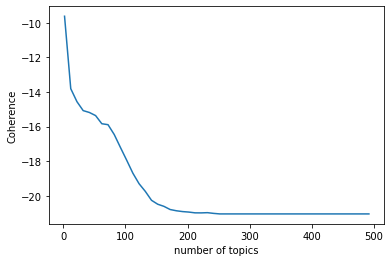

In [30]:
test_model(data.summary, range(2, 500, 10))

In [31]:
model, vis = get_solution(data.summary, 100)

/home/breengles/.pyenv/versions/3.8.11/envs/ml/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [32]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11    -0.356147  0.148889       1        1  2.431658
54     0.214796 -0.087636       2        1  1.934273
58     0.268282  0.205453       3        1  1.922614
17     0.191230 -0.348815       4        1  1.885196
35     0.349597  0.118468       5        1  1.880922
...         ...       ...     ...      ...       ...
24    -0.000706  0.004784      96        1  0.198405
25    -0.000706  0.004784      97        1  0.198405
82    -0.000706  0.004784      98        1  0.198405
81     0.066724 -0.084969      99        1  0.198405
99    -0.000706  0.004784     100        1  0.198405

[100 rows x 5 columns], topic_info=         Term       Freq      Total  Category  logprob  loglift
24     import  55.000000  55.000000   Default  30.0000  30.0000
9        type  54.000000  54.000000   Default  29.0000  29.0000
29     django  27.000000  27.000000   Default  28.0000  28.0000
8     pycharm  60.000000  60.000000   Default  27.0000  27.0000
13     python  58.000000  58.000000   Default  26.0000  26.0000
..        ...        ...        ...       ...      ...      ...
24     import   0.024278  55.292506  Topic100  -5.1059  -1.5082
25      posit   0.024278  18.017909  Topic100  -5.1059  -0.3870
26  statement   0.024278   8.457895  Topic100  -5.1059   0.3693
27      class   0.024278  29.537818  Topic100  -5.1059  -0.8813
29     django   0.024278  27.213539  Topic100  -5.1059  -0.7993

[4780 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
79        9  0.160196  action
79       26  0.320391  action
79       37  0.160196  action
42        9  0.093542     add
42       21  0.187085     add
...     ...       ...     ...
49       45  0.091110   wrong
49       55  0.045555   wrong
49       56  0.045555   wrong
49       62  0.045555   wrong
49       71  0.045555   wrong

[932 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 55, 59, 18, 36, 67, 84, 6, 97, 74, 21, 19, 13, 35, 69, 62, 51, 31, 53, 52, 79, 64, 89, 42, 29, 92, 96, 28, 58, 88, 20, 5, 10, 93, 37, 9, 7, 91, 57, 39, 41, 16, 47, 17, 68, 14, 8, 85, 72, 50, 60, 78, 27, 34, 30, 80, 54, 1, 2, 4, 56, 75, 86, 95, 22, 98, 11, 65, 44, 76, 70, 66, 24, 81, 94, 90, 46, 77, 32, 23, 61, 33, 71, 99, 3, 49, 63, 48, 45, 15, 43, 38, 73, 87, 40, 25, 26, 83, 82, 100])

А тут уже что-то другое: проблемы с брейкпоинтами и консолью, окном дебага (?), что-то с типами опять (как было и в 2020.2 версии, но дополнительно появился какой-то другой аспект, видимо, мне сложно судить, так как не работал глубоко с пайчармом...), появились проблемы с конфигурацией интерпретатора питона, 

In [33]:
get_major_topic(model)

Topic: 1 
Words: 0.147*"django" + 0.074*"project" + 0.074*"select" + 0.074*"creat" + 0.074*"reset" + 0.074*"close" + 0.074*"interpret" + 0.074*"run" + 0.074*"set" + 0.074*"exist"
Topic: 2 
Words: 0.104*"type" + 0.083*"close" + 0.083*"jupyt" + 0.083*"run" + 0.083*"debugg" + 0.083*"cannot" + 0.083*"project" + 0.061*"list" + 0.057*"code" + 0.051*"annot"
Topic: 3 
Words: 0.006*"stick" + 0.006*"close" + 0.006*"line" + 0.006*"return" + 0.006*"sciview" + 0.006*"docker" + 0.006*"invalid" + 0.006*"open" + 0.006*"resolv" + 0.006*"level"
Topic: 4 
Words: 0.086*"sourc" + 0.086*"symbol" + 0.086*"file" + 0.086*"import" + 0.086*"move" + 0.086*"pycharm" + 0.086*"chang" + 0.086*"use" + 0.037*"base" + 0.033*"project"
Topic: 5 
Words: 0.093*"method" + 0.093*"argument" + 0.047*"valu" + 0.047*"wrong" + 0.047*"use" + 0.047*"pycharm" + 0.047*"fals" + 0.047*"base" + 0.047*"work" + 0.047*"configur"
Topic: 6 
Words: 0.150*"packag" + 0.075*"declar" + 0.075*"import" + 0.038*"use" + 0.038*"init" + 0.038*"dunder" +

Оо, вылезли проблемы с джанго фреймворком...